In [ ]:
# Full code

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# Load dataset
file_path = "/content/drive/MyDrive/DSAI_Capstone/walmart.csv"
df = pd.read_csv(file_path, parse_dates=['Date'])

# Data cleaning and preparation steps
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Outlier Removal
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Apply the outlier removal function on 'Weekly_Sales' & 'Temperature'
df = remove_outliers(df, 'Weekly_Sales')
df = remove_outliers(df, 'Temperature')


# Feature Engineering: Create additional features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week

# Select numerical columns for scaling
numerical_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Sort data by Store and Date
df.sort_values(by=['Store', 'Date'], inplace=True)

clean_df = df.copy()



##################################################################
# Extract unique store IDs
stores = df['Store'].unique()
stores.sort()

# Dictionary to store the forecasts
forecasts = {
    "Store": [],
    "Date": [],
    "Actual": [],
    "SARIMA": [],
    "Holt-Winters": [],
    "ARIMA": []
}

# Function to fit and forecast with SARIMA model
def forecast_sarima(train, test, order):
    try:
        model = SARIMAX(train, order=order, seasonal_order=(1, 1, 1, 52)).fit(disp=False)
        forecast = model.forecast(len(test))
        return forecast
    except Exception as e:
        print(f"Error with SARIMA: {e}")
        return [None] * len(test)

# Function to fit and forecast with Holt-Winters model
def forecast_holt_winters(train, test):
    try:
        model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=52).fit()
        forecast = model.forecast(len(test))
        return forecast
    except Exception as e:
        print(f"Error with Holt-Winters: {e}")
        return [None] * len(test)

# Function to fit and forecast with ARIMA model
def forecast_arima(train, test, order):
    try:
        model = ARIMA(train, order=order).fit()
        forecast = model.forecast(steps=len(test))
        return forecast
    except Exception as e:
        print(f"Error with ARIMA for store: {e}")
        return [None] * len(test)

# Function to perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    return result[1]  # p-value

# Function to determine the value of d
def determine_d(series):
    p_value = adf_test(series)
    if p_value < 0.05:
        return 0  # No differencing needed
    else:
        return 1  # Differencing needed

# Function to find the best ARIMA order
def arima_grid_search(y, p_values, d, q_values):
    best_aic = float("inf")
    best_order = None
    for p in p_values:
        for q in q_values:
            try:
                model = ARIMA(y, order=(p, d, q))
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
            except:
                continue
    return best_order

# Define parameter ranges
p_values = range(0, 3)
q_values = range(0, 3)

store_orders = {}

# Forecasting for each store
for store in stores:
    store_data = df[df['Store'] == store]
    store_data.set_index('Date', inplace=True)
    store_data.sort_index(inplace=True)
    store_data = store_data['Weekly_Sales'].resample('W').sum()

    train = store_data[:-12]
    test = store_data[-12:]

    # Determine d value
    d = determine_d(store_data)

    # Find the best ARIMA order
    best_order = arima_grid_search(store_data, p_values, d, q_values)

    store_orders[store] = {
        'arima_order': best_order,
    }

    sarima_forecast = forecast_sarima(train, test, best_order)
    hw_forecast = forecast_holt_winters(train, test)
    arima_forecast = forecast_arima(train, test, best_order)

    # Add the forecasts to the dictionary
    for date, actual, sarima, hw, arima in zip(test.index, test.values, sarima_forecast, hw_forecast, arima_forecast):
        forecasts["Store"].append(store)
        forecasts["Date"].append(date)
        forecasts["Actual"].append(actual)
        forecasts["SARIMA"].append(sarima)
        forecasts["Holt-Winters"].append(hw)
        forecasts["ARIMA"].append(arima)

# Convert to DataFrame
forecast_df = pd.DataFrame(forecasts)
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

print(forecast_df.head(1))
print(store_orders)


#####
# Prepare features for Random Forest
rf_df = df.set_index('Date')
X = rf_df.drop(columns=['Weekly_Sales'])
y = rf_df['Weekly_Sales']

# Ensure the test set has the same dates as the forecast_df
cutoff_date = pd.to_datetime(df['Date'].max() - pd.DateOffset(weeks=12))
test_dates = forecast_df['Date']
X_train = X[X.index <= cutoff_date]
y_train = y[y.index <= cutoff_date]
X_test = X[X.index > cutoff_date]
y_test = y[y.index > cutoff_date]

if not X_train.empty and not y_train.empty:
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    if not X_test.empty:
        rf_forecast = rf.predict(X_test)
    else:
        rf_forecast = [None] * len(test_dates)
else:
    rf_forecast = [None] * len(test_dates)

# Convert the Random Forest forecasts to a DataFrame
rf_forecast_df = pd.DataFrame({
    'Store': forecast_df['Store'],
    'Date': forecast_df['Date'],
    'Random_Forest': rf_forecast
})

# Concatenate the Random Forest forecasts to the original forecast DataFrame
forecast_df['Random_Forest'] = rf_forecast_df['Random_Forest']

print(forecast_df.head())


################################################################
# Evaluate the models
results = []

for store in stores:
    store_data = forecast_df[forecast_df['Store'] == store]
    actual = store_data['Actual'].values
    sarima_forecast = store_data['SARIMA'].values
    holt_forecast = store_data['Holt-Winters'].values
    arima_forecast = store_data['ARIMA'].values
    rf_forecast = store_data['Random_Forest'].values

    # Calculate MAE, MSE, RMSE for SARIMA
    sarima_mae = mean_absolute_error(actual, sarima_forecast)
    sarima_mse = mean_squared_error(actual, sarima_forecast)
    sarima_rmse = np.sqrt(sarima_mse)

    # Calculate MAE, MSE, RMSE for Holt-Winters
    holt_mae = mean_absolute_error(actual, holt_forecast)
    holt_mse = mean_squared_error(actual, holt_forecast)
    holt_rmse = np.sqrt(holt_mse)

    # Calculate MAE, MSE, RMSE for ARIMA
    arima_mae = mean_absolute_error(actual, arima_forecast)
    arima_mse = mean_squared_error(actual, arima_forecast)
    arima_rmse = np.sqrt(arima_mse)

    # Calculate MAE, MSE, RMSE for Random Forest
    rf_mae = mean_absolute_error(actual, rf_forecast)
    rf_mse = mean_squared_error(actual, rf_forecast)
    rf_rmse = np.sqrt(rf_mse)

    # Append to results list
    results.append({
        'Store': store,
        'Model': 'SARIMA',
        'MAE': sarima_mae,
        'MSE': sarima_mse,
        'RMSE': sarima_rmse
    })
    results.append({
        'Store': store,
        'Model': 'Holt-Winters',
        'MAE': holt_mae,
        'MSE': holt_mse,
        'RMSE': holt_rmse
    })
    results.append({
        'Store': store,
        'Model': 'ARIMA',
        'MAE': arima_mae,
        'MSE': arima_mse,
        'RMSE': arima_rmse
    })
    results.append({
        'Store': store,
        'Model': 'Random Forest',
        'MAE': rf_mae,
        'MSE': rf_mse,
        'RMSE': rf_rmse
    })

# Convert results to DataFrame
metrics_df = pd.DataFrame(results)

# Print the metrics
print(metrics_df)

# Compare the models
comparison_df = metrics_df.groupby('Model').mean().reset_index()
comparison_df.drop('Store', axis=1, inplace=True)
comparison_df.set_index('Model', inplace=True)
print(comparison_df)


#########################################################
# Plot forecasts with actual sales for all stores
import matplotlib.pyplot as plt

# Set up the figure and axes
n_stores = len(stores)
n_rows = (n_stores + 2) // 3  # Calculate number of rows needed for 3 subplots per row

fig, axes = plt.subplots(n_rows, 3, figsize=(20, 5 * n_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot data for each store
for i, store in enumerate(stores):
    ax = axes[i]
    store_data = forecast_df[forecast_df['Store'] == store]
    dates = store_data['Date']
    actual = store_data['Actual']
    sarima_forecast = store_data['SARIMA']
    holt_forecast = store_data['Holt-Winters']
    arima_forecast = store_data['ARIMA']
    rf_forecast = store_data['Random_Forest']


    ax.plot(dates, actual, label='Actual', marker='o')
    ax.plot(dates, sarima_forecast, label='SARIMA Forecast', marker='x')
    ax.plot(dates, holt_forecast, label='Holt-Winters Forecast', marker='x')
    ax.plot(dates, arima_forecast, label='ARIMA Forecast', marker='x')
    ax.plot(dates, rf_forecast, label='Random Forest Forecast', marker='x')


    ax.set_title(f'Store {store}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales')

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.25, top=0.97)

# Add a single legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes if ax.has_data()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:5], labels[:5], loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.98))

plt.show()


In [3]:
# Load dataset
file_path = "/content/drive/MyDrive/DSAI_Capstone/walmart.csv"
df = pd.read_csv(file_path, parse_dates=['Date'])

# Data cleaning and preparation steps
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Outlier Removal
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Apply the outlier removal function on 'Weekly_Sales' & 'Temperature'
df = remove_outliers(df, 'Weekly_Sales')
df = remove_outliers(df, 'Temperature')


# Feature Engineering: Create additional features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week

# Select numerical columns for scaling
numerical_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Sort data by Store and Date
df.sort_values(by=['Store', 'Date'], inplace=True)

clean_df = df.copy()

In [4]:

# Prepare features for Random Forest
rf_df = df.set_index('Date')
X = rf_df.drop(columns=['Weekly_Sales'])
y = rf_df['Weekly_Sales']

# Ensure the test set has the same dates as the forecast_df
cutoff_date = pd.to_datetime(df['Date'].max() - pd.DateOffset(weeks=12))
test_dates = forecast_df['Date']
X_train = X[X.index <= cutoff_date]
y_train = y[y.index <= cutoff_date]
X_test = X[X.index > cutoff_date]
y_test = y[y.index > cutoff_date]

if not X_train.empty and not y_train.empty:
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    if not X_test.empty:
        rf_forecast = rf.predict(X_test)
    else:
        rf_forecast = [None] * len(test_dates)
else:
    rf_forecast = [None] * len(test_dates)

# Convert the Random Forest forecasts to a DataFrame
rf_forecast_df = pd.DataFrame({
    'Store': forecast_df['Store'],
    'Date': forecast_df['Date'],
    'Random_Forest': rf_forecast
})

# Concatenate the Random Forest forecasts to the original forecast DataFrame
forecast_df['Random_Forest'] = rf_forecast_df['Random_Forest']

print(forecast_df.head())



####################################################
# Evaluate the model
results = []

for store in stores:
    store_data = forecast_df[forecast_df['Store'] == store]
    actual = store_data['Actual'].values
    sarima_forecast = store_data['SARIMA'].values
    holt_forecast = store_data['Holt-Winters'].values
    arima_forecast = store_data['ARIMA'].values
    rf_forecast = store_data['Random_Forest'].values

    # Calculate MAE, MSE, RMSE for SARIMA
    sarima_mae = mean_absolute_error(actual, sarima_forecast)
    sarima_mse = mean_squared_error(actual, sarima_forecast)
    sarima_rmse = np.sqrt(sarima_mse)

    # Calculate MAE, MSE, RMSE for Holt-Winters
    holt_mae = mean_absolute_error(actual, holt_forecast)
    holt_mse = mean_squared_error(actual, holt_forecast)
    holt_rmse = np.sqrt(holt_mse)

    # Calculate MAE, MSE, RMSE for ARIMA
    arima_mae = mean_absolute_error(actual, arima_forecast)
    arima_mse = mean_squared_error(actual, arima_forecast)
    arima_rmse = np.sqrt(arima_mse)

    # Calculate MAE, MSE, RMSE for Random Forest
    rf_mae = mean_absolute_error(actual, rf_forecast)
    rf_mse = mean_squared_error(actual, rf_forecast)
    rf_rmse = np.sqrt(rf_mse)

    # Append to results list
    results.append({
        'Store': store,
        'Model': 'SARIMA',
        'MAE': sarima_mae,
        'MSE': sarima_mse,
        'RMSE': sarima_rmse
    })
    results.append({
        'Store': store,
        'Model': 'Holt-Winters',
        'MAE': holt_mae,
        'MSE': holt_mse,
        'RMSE': holt_rmse
    })
    results.append({
        'Store': store,
        'Model': 'ARIMA',
        'MAE': arima_mae,
        'MSE': arima_mse,
        'RMSE': arima_rmse
    })
    results.append({
        'Store': store,
        'Model': 'Random Forest',
        'MAE': rf_mae,
        'MSE': rf_mse,
        'RMSE': rf_rmse
    })

# Convert results to DataFrame
metrics_df = pd.DataFrame(results)

# Print the metrics
print(metrics_df)

# Compare the models
comparison_df = metrics_df.groupby('Model').mean().reset_index()
comparison_df.drop('Store', axis=1, inplace=True)
comparison_df.set_index('Model', inplace=True)
print(comparison_df)




   Store       Date    Actual    SARIMA  Holt-Winters     ARIMA  Random_Forest
0      1 2012-08-12  1.020059  1.048837      1.029403  0.783336       0.993781
1      1 2012-08-19  1.030069  1.047681      1.036680  1.037756       0.986470
2      1 2012-08-26  0.839794  0.936344      0.915151  0.939187       0.984414
3      1 2012-09-02  1.001119  1.087260      1.074749  0.922247       0.983659
4      1 2012-09-09  1.147263  1.066315      1.033504  0.986846       1.043172
     Store          Model       MAE       MSE      RMSE
0        1         SARIMA  0.062844  0.005109  0.071476
1        1   Holt-Winters  0.059999  0.005062  0.071146
2        1          ARIMA  0.115484  0.018798  0.137107
3        1  Random Forest  0.105756  0.015593  0.124871
4        2         SARIMA  0.087077  0.013323  0.115426
..     ...            ...       ...       ...       ...
175     44  Random Forest  0.016687  0.000482  0.021964
176     45         SARIMA  0.041929  0.002201  0.046914
177     45   Holt-Wint

In [5]:
forecast_df.head()

,Store,Date,Actual,SARIMA,Holt-Winters,ARIMA,Random_Forest
0,1,2012-08-12,1.020059,1.048837,1.029403,0.783336,0.993781
1,1,2012-08-19,1.030069,1.047681,1.036680,1.037756,0.986470
2,1,2012-08-26,0.839794,0.936344,0.915151,0.939187,0.984414
3,1,2012-09-02,1.001119,1.087260,1.074749,0.922247,0.983659
4,1,2012-09-09,1.147263,1.066315,1.033504,0.986846,1.043172


In [6]:
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Store          540 non-null    int64         
 1   Date           540 non-null    datetime64[ns]
 2   Actual         540 non-null    float64       
 3   SARIMA         540 non-null    float64       
 4   Holt-Winters   540 non-null    float64       
 5   ARIMA          540 non-null    float64       
 6   Random_Forest  540 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 29.7 KB


In [7]:
forecast_df.to_csv('forecast.csv', index=False)

In [8]:
metrics_df.head()

,Store,Model,MAE,MSE,RMSE
0,1,SARIMA,0.062844,0.005109,0.071476
1,1,Holt-Winters,0.059999,0.005062,0.071146
2,1,ARIMA,0.115484,0.018798,0.137107
3,1,Random Forest,0.105756,0.015593,0.124871
4,2,SARIMA,0.087077,0.013323,0.115426


In [9]:
metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Store   180 non-null    int64  
 1   Model   180 non-null    object 
 2   MAE     180 non-null    float64
 3   MSE     180 non-null    float64
 4   RMSE    180 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 7.2+ KB


In [10]:
metrics_df.to_csv('metrics.csv', index=False)

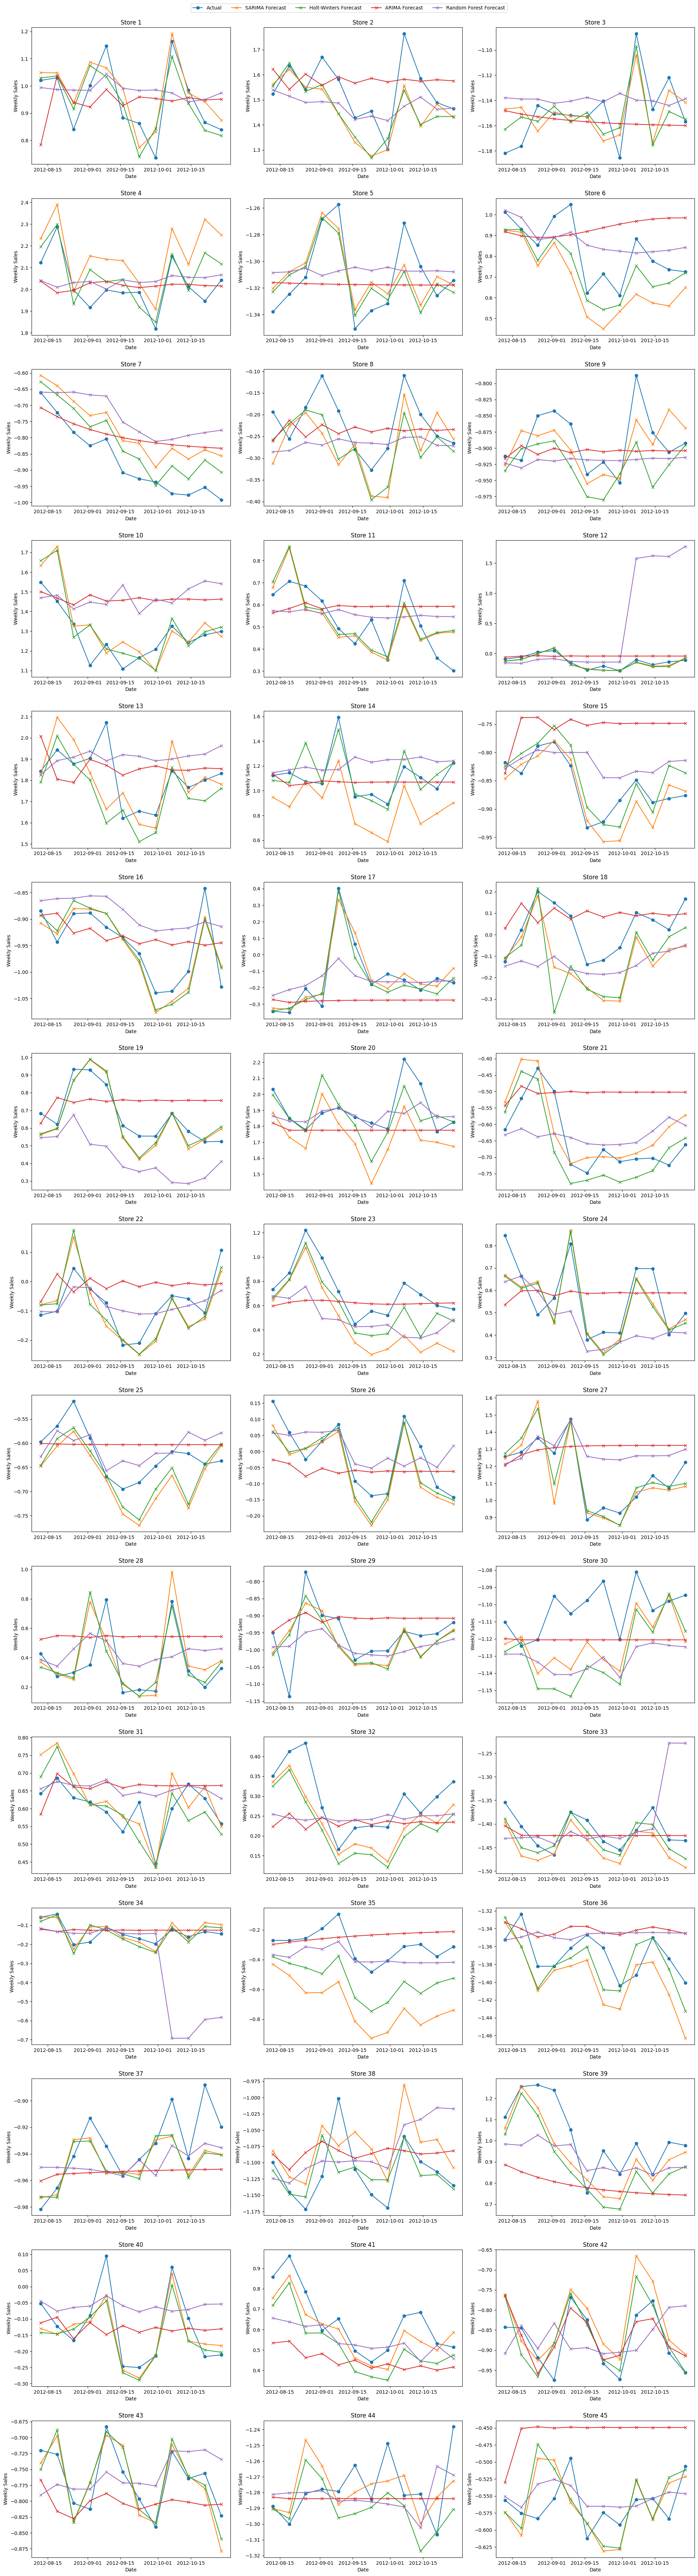

In [11]:
import matplotlib.pyplot as plt

# Set up the figure and axes
n_stores = len(stores)
n_rows = (n_stores + 2) // 3  # Calculate number of rows needed for 3 subplots per row

fig, axes = plt.subplots(n_rows, 3, figsize=(20, 5 * n_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot data for each store
for i, store in enumerate(stores):
    ax = axes[i]
    store_data = forecast_df[forecast_df['Store'] == store]
    dates = store_data['Date']
    actual = store_data['Actual']
    sarima_forecast = store_data['SARIMA']
    holt_forecast = store_data['Holt-Winters']
    arima_forecast = store_data['ARIMA']
    rf_forecast = store_data['Random_Forest']


    ax.plot(dates, actual, label='Actual', marker='o')
    ax.plot(dates, sarima_forecast, label='SARIMA Forecast', marker='x')
    ax.plot(dates, holt_forecast, label='Holt-Winters Forecast', marker='x')
    ax.plot(dates, arima_forecast, label='ARIMA Forecast', marker='x')
    ax.plot(dates, rf_forecast, label='Random Forest Forecast', marker='x')


    ax.set_title(f'Store {store}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales')

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.25, top=0.97)

# Add a single legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes if ax.has_data()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:5], labels[:5], loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.98))

plt.show()
